# Setting up DenseCap for interactive use
   
We have have several models trained using DenseCap's localization layer; however, we need to access different model layers to make comparisions against other models. In this notebook, we've created an environment to interactively access DenseCap layers.

### Important note:
Using `local` variable scope will restrict variables to use **within** a cell. This is potentially the reason you are getting errors about `nil` values.

In [1]:
-- All the required packages extracted from various parts of DenseCap code
require 'torch'
require 'nn'
require 'image'
require 'hdf5'
require 'cutorch'
require 'cunn'
require 'cudnn'
require 'image'
require 'densecap.DenseCapModel'
utils = require 'densecap.utils'
box_utils = require 'densecap.box_utils'

### Model options
There are a number of specified options in DenseCap. We'll collect them here for easy access

In [2]:
checkpoint_path = 'models/single-object/checkpoint.t7'
rpn_nms_thresh = 0.7
final_nms_thresh = 0.4
num_proposals = 1000
image_size = 720

This lets us use GPU! Otherwise you will get errors later on particularly when you go to use the model. 
You'll get a helpfuly error that says something like: 
    
    `...torch/install/share/lua/5.1/cudnn/SpatialConvolution.lua:33: Only Cuda supported duh!`

In [3]:
cutorch.setDevice(1)
dtype, use_cudnn = 'torch.CudaTensor', true

Load the model from a checkpoint. **DO NOT PRINT THIS RESULT!!!!!!** There are several 
avaialable properties here but we really only care about accessing the model.

In [4]:
checkpoint = torch.load(checkpoint_path)

In [5]:
model = checkpoint.model
model:convert(dtype, use_cudnn)
model:setTestArgs{
    rpn_nms_thresh = rpn_nms_thresh,
    final_nms_thresh = final_nms_thresh,
    num_proposals = num_proposals,
  }
model:evaluate()

In [6]:
-- path to random test image 
test_image = 'visual-genome/images/1000.jpg'
-- load it up
img = image.load(test_image, 3)

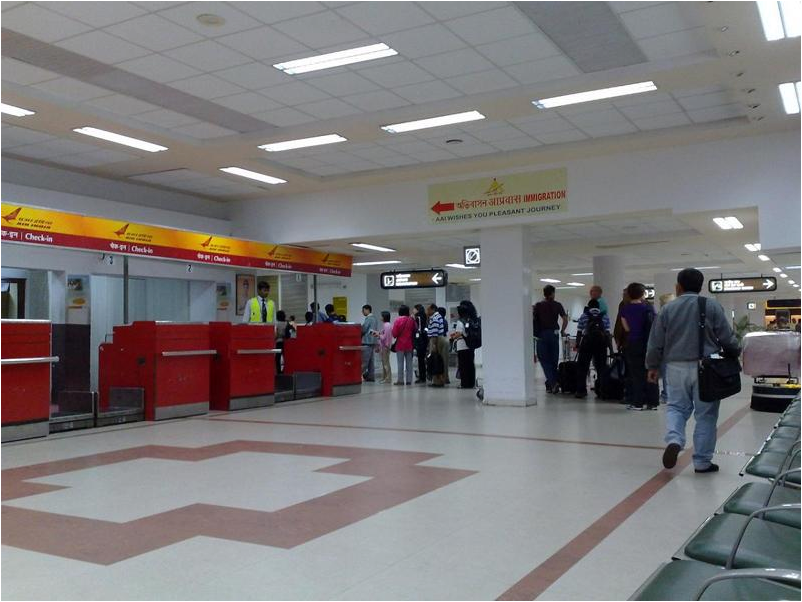

In [7]:
-- Display for funzies
itorch.image({img})

## Image preprocessing
DenseCap does some image preprocessing to play nice with the underlying Caffe VGG network. We'll do that too!

In [8]:
--[[
Function preforms neccessary image preprocessing

Input:
- img: image object. Use image.load to create
- im_size: integer. Used for rescaling the image. Should be the same specified in the mode.
    Default for DenseCap is 720
Returns:
- img_caffe: formatted image for the model. Will be a 4 tensor [1, 3, H, W]
--]]
function preprocess_image(img, im_size)
    -- Load, resize, and preprocess image
    img = image.scale(img, im_size):float()
    local H, W = img:size(2), img:size(3)
    local img_caffe = img:view(1, 3, H, W)
    img_caffe = img_caffe:index(2, torch.LongTensor{3, 2, 1}):mul(255)
    local vgg_mean = torch.FloatTensor{103.939, 116.779, 123.68}
    vgg_mean = vgg_mean:view(1, 3, 1, 1):expand(1, 3, H, W)
    img_caffe:add(-1, vgg_mean)
    return img_caffe
end

In [9]:
processed_img = preprocess_image(img, image_size):type(dtype)

In [10]:
--boxes_xcycwh, feats = model:extractFeatures(processed_img:type(dtype))

In [11]:
height, width = processed_img:size(3), processed_img:size(4)
model.nets.localization_layer:setImageSize(height, width)
output = model.net:forward(processed_img)

In [12]:
-- The different macro layer names
local i = 1
for k,v in pairs(model.nets) do
    print(string.format("%i: %s", i, k))
    i = i + 1
end

-- LSTM output tokens
token_sequence = output[5]

1: recog_net	
2: objectness_branch	
3: conv_net1	
4: box_reg_branch	
5: language_model	
6: localization_layer	
7: conv_net2	
8: recog_base	


## Let's look at the RNN's guts!
We can access each one of these elements in the rnn using their index and then by name. For example, to access the second element's outputs you'd write 

    model.nets.language_model['rnn'].modules[1]['outputs']

In [13]:
print(model.nets.language_model['rnn'].modules)

{
  1 : 
    nn.LSTM(512 -> 512)
    {
      _return_grad_c0 : false
      output : CudaTensor - size: 1000x1x512
  

    gradInput : CudaTensor - empty
      cell : CudaTensor - size: 1000x1x512
      buffer1 : CudaTensor - empty
      input_dim : 512
      _type : torch.CudaTensor
      grad_x : CudaTensor - empty
      hidden_dim : 512
      buffer3 : CudaTensor - empty
      gradBias : CudaTensor - size: 2048
      recompute_backward : true
      bias : CudaTensor - size: 2048
      c0 : CudaTensor - empty
      _return_grad_h0 : false
      remember_states : false
      h0 : CudaTensor - empty
      grad_a_buffer : CudaTensor - empty
      weight : CudaTensor - size: 1024x2048
      train : false
      gradWeight : CudaTensor - size: 1024x2048
      gates : CudaTensor - size: 1000x1x2048
      buffer2 : CudaTensor - empty
      grad_h0 : CudaTensor - empty
      grad_c0 : CudaTensor - empty
    }
  2 : 
    nn.View(1000, -1)
    {
      train : false
      _type : torch.CudaTensor
      output : CudaTensor - size: 1000x512
      gradInput : CudaTensor - empty
      numElements : 1000
      numInp

 gradBias : CudaTensor - size: 4689
      output : CudaTensor - size: 1000x4689
      gradInput : CudaTensor - empty
      weight : CudaTensor - size: 4689x512
      _type : torch.CudaTensor
      gradWeight : CudaTensor - size: 4689x512
      addBuffer : CudaTensor - size: 1000
      bias : CudaTensor - size: 4689
      train : false
    }
  4 : 
    nn.View(1000, 1, -1)
    {
      train : false
      _type : torch.CudaTensor
      output : CudaTensor - size: 1000x1x4689
      gradInput : CudaTensor - empty
      numElements : 1000
      numInputDims : 2
      size : LongStorage - size: 3
    }
}


## RNN Outputs
Everytime you run the model forward, each component updates it's `output` property. Using the above access method, we can get to the most recent RNN output

In [16]:
rnn = model.nets.language_model['rnn']
rnn_out = rnn.output:view(1000, -1)

In [6]:
max, idx = torch.max(rnn_out, 2)

Here were have developed a wrapper to access the RNN layer's outputs. A user will feed in an image, the model will run, and the raw RNN outputs are returned

In [ ]:
probs = model:extractWordProbs(processed_img)

## At a higher level
We can just access the predicted tokens for bounding box and decode them

In [ ]:
-- Decode the sequence with the language model
decoded_sequence = model.nets.language_model:decodeSequence(token_sequence)

Let's check out some of the decoded terms

In [ ]:
for i=1,5 do
    print(decoded_sequence[i])
end

## TODO 
Show output!